In [1]:
from os import path
%matplotlib inline
from pyprojroot import here
workspace_path = '/Users/seyongpark/Projects/Autolens'
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import autolens as al
import autolens.plot as aplt
import matplotlib.pylab as plt
import numpy as np
from scipy.interpolate import griddata
from astropy.cosmology import FlatLambdaCDM

/Users/seyongpark/Projects/Autolens
Working Directory has been set to `/Users/seyongpark/Projects/Autolens`


## Glafic Model

In [2]:
# load magnification data
magnif_path = path.join("glafic-model",\
                        "hlsp_relics_model_model_whl0137-08_glafic_v1_z06p2-magnif.fits")
magnif = al.Array2D.from_fits(file_path=magnif_path,pixel_scales=0.1)

# find maximum maginification
ind = np.unravel_index(np.argmax(magnif.native, axis=None), magnif.native.shape)
print("Location of Max Magnification: ({:.2f}, {:.2f})".format(ind[0]*0.1-60,ind[1]*0.1-60))

# locate points of highest magnification
magnif_peaks = np.array(np.where(magnif.native>100000))*0.1-60

# compute grid values
N = 1200
x = np.linspace(-60, 60, N)
y = np.linspace(-60, 60, N)
X, Y = np.meshgrid(x, y)
Y = -Y # pyautolens and numpy use different conventions

Location of Max Magnification: (26.30, 30.30)


(-35.0, -25.0)

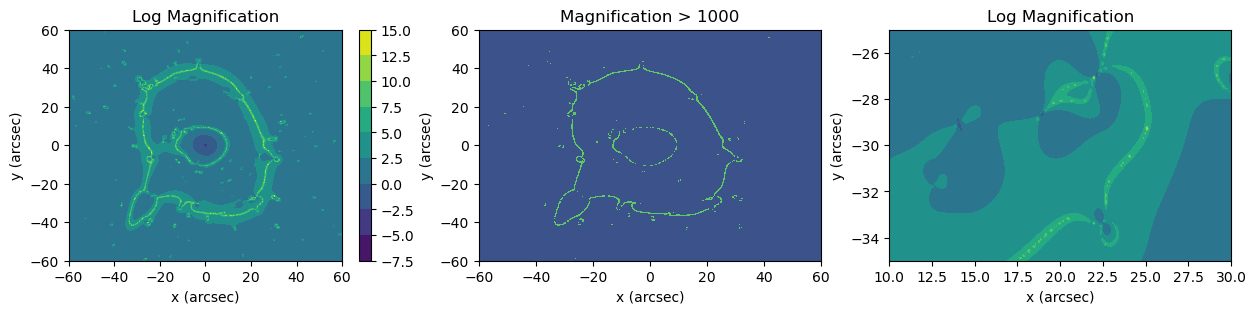

In [3]:
plt.figure(figsize=(15,3))
 
# plot log of magnification
plt.subplot(1,3,1)
plt.contourf(X,Y,np.log(magnif.native),origin="upper")
plt.xlabel("x (arcsec)")
plt.ylabel("y (arcsec)")
plt.colorbar()
plt.title("Log Magnification")

plt.subplot(1,3,2)
plt.contourf(X,Y,magnif.native>1000)
plt.title("Magnification > 1000")
plt.xlabel("x (arcsec)")
plt.ylabel("y (arcsec)")

plt.subplot(1,3,3)
plt.contourf(X,Y,np.log(magnif.native))
plt.title("Log Magnification")
plt.xlabel("x (arcsec)")
plt.ylabel("y (arcsec)")
plt.xlim([10,30])
plt.ylim([-35,-25])

(-40.0, -20.0)

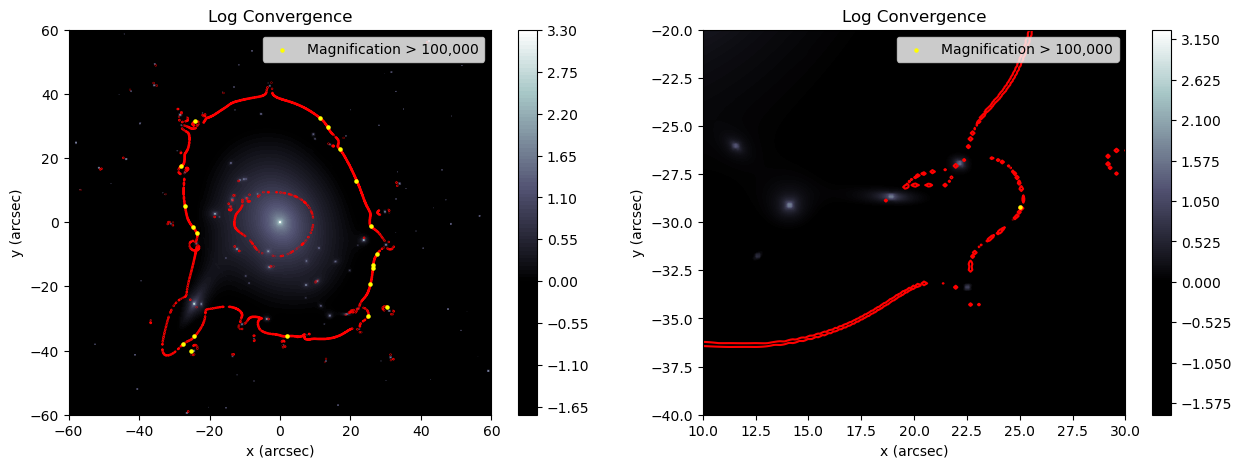

In [4]:
# read convergence from fits files
kappa_path = path.join("glafic-model","hlsp_relics_model_model_whl0137-08_glafic_v1_kappa.fits")
kappa = al.Array2D.from_fits(file_path=kappa_path,pixel_scales=0.1)

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.contourf(X,Y,np.log(kappa.native),levels=100,vmin=0,cmap="bone")
plt.xlabel("x (arcsec)")
plt.ylabel("y (arcsec)")
plt.colorbar()
plt.title("Log Convergence")
plt.contour(X,Y,magnif.native,levels=[1000],colors="red")
plt.scatter(magnif_peaks[1],-magnif_peaks[0],color="yellow",s=5,zorder=5,label="Magnification > 100,000")
#plt.scatter([25],[-29.2],color="lime",zorder=10,s=50)
plt.legend()

plt.subplot(1,2,2)
plt.contourf(X,Y,np.log(kappa.native),levels=200,vmin=0,cmap="bone")
plt.xlabel("x (arcsec)")
plt.ylabel("y (arcsec)")
plt.colorbar()
plt.title("Log Convergence")
plt.contour(X,Y,magnif.native,levels=[800],colors="red")
plt.scatter(magnif_peaks[1],-magnif_peaks[0],color="yellow",s=5,zorder=5,label="Magnification > 100,000")
#plt.scatter([25],[-29.2],color="lime",zorder=10,s=40)
plt.legend()
# plt.xlim([10,35])
# plt.ylim([-40,-15])
plt.xlim([10,30])
plt.ylim([-40,-20])

In [5]:
# locate peak magnification with (-25,-35) x (10,30)
peak_x = magnif_peaks[1][(-magnif_peaks[0] < -25) & (-magnif_peaks[0] > -35)\
                & (magnif_peaks[1] > 10) & (magnif_peaks[1] < 30)]
peak_y = -magnif_peaks[0][(-magnif_peaks[0] < -25) & (-magnif_peaks[0] > -35)\
                & (magnif_peaks[1] > 10) & (magnif_peaks[1] < 30)]
print("Earendel Location: {:.2f} {:.2f}".format(peak_y[0],peak_x[0]))

Earendel Location: -29.20 25.00


## Deflection Angles

In [6]:
# compute scaling ratio for deflection angles
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

D_ds = cosmo.angular_diameter_distance_z1z2(0.566,6.2) # distance from source to lens
D_s = cosmo.angular_diameter_distance_z1z2(0,6.2) # distance to source
ratio = D_ds/D_s

print("D_ds: {:.2f} D_s: {:.2f}  Scale Factor: {:.4f}".format(D_ds,D_s,ratio))

D_ds: 865.12 Mpc D_s: 1156.85 Mpc  Scale Factor: 0.7478


In [9]:
# paths for deflection data
x_path = path.join("glafic-model","hlsp_relics_model_model_whl0137-08_glafic_v1_x-arcsec-deflect.fits")
y_path = path.join("glafic-model","hlsp_relics_model_model_whl0137-08_glafic_v1_y-arcsec-deflect.fits")

scale = 0.1 # computed from comparing pixel and arcsec files

# read in deflection data
deflections_y = al.Array2D.from_fits(
    file_path=y_path,
    pixel_scales=scale,
)
deflections_x = al.Array2D.from_fits(
    file_path=x_path,
    pixel_scales=scale,
)

# scale deflection angles to account for redshift
deflections_y = al.Array2D.no_mask(ratio*deflections_y.native, 
                                   pixel_scales = scale)
deflections_x = al.Array2D.no_mask(ratio*deflections_x.native, 
                                   pixel_scales = scale)

# construct mass profile using deflections
deflections_plane_grid_2d = al.Grid2D.uniform(
    shape_native=deflections_y.shape_native,
    pixel_scales=scale,  # The pixel-scale describes the conversion from pixel units to arc-seconds
)
input_deflections = al.mp.InputDeflections(
    deflections_y=deflections_y,
    deflections_x=deflections_x,
    image_plane_grid=deflections_plane_grid_2d
)

In [11]:
# compute convergence and magnification from deflections
deflections_kappa = input_deflections.convergence_2d_from(deflections_plane_grid_2d)
deflections_magnif = input_deflections.magnification_2d_from(deflections_plane_grid_2d)

# save data to file
np.save("autolens_kappa.npy", deflections_kappa.native)
np.save("autolens_magnif.npy", deflections_magnif.native)

# test if convergence computed from deflections matches convergence from fits file
np.allclose(magnif.native,np.abs(deflections_magnif.native),1)

False

In [15]:
# load data from file to avoid waiting for the block above
deflections_kappa = al.Array2D.no_mask(np.load("autolens_kappa.npy"), 
                                   pixel_scales = scale)
deflections_magnif = al.Array2D.no_mask(np.load("autolens_magnif.npy"), 
                                   pixel_scales = scale)

(-40.0, -20.0)

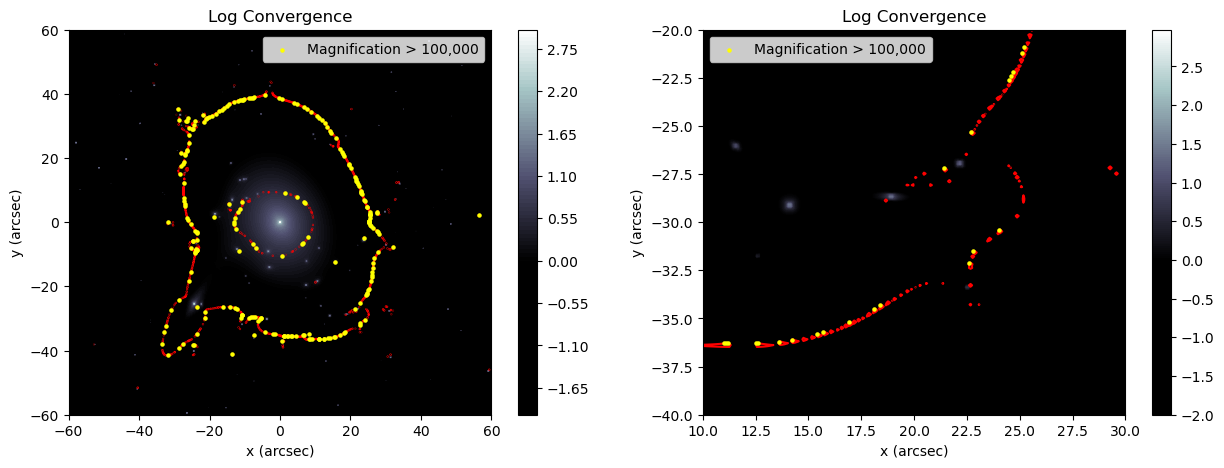

In [16]:
deflections_magnif_peaks = np.array(np.where(deflections_magnif.native>5000))*0.1-60

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.contourf(X,Y,np.log(deflections_kappa.native),levels=100,cmap="bone",vmin=0)
plt.xlabel("x (arcsec)")
plt.ylabel("y (arcsec)")
plt.colorbar()
plt.title("Log Convergence")
plt.contour(X,Y,deflections_magnif.native,levels=[800],colors="red")
plt.scatter(deflections_magnif_peaks[1],-deflections_magnif_peaks[0],\
            color="yellow",s=5,zorder=5,label="Magnification > 100,000")
plt.legend()

plt.subplot(1,2,2)
plt.contourf(X,Y,np.log(deflections_kappa.native),levels=200,cmap="bone",vmin=0)
plt.xlabel("x (arcsec)")
plt.ylabel("y (arcsec)")
plt.colorbar()
plt.title("Log Convergence")
plt.contour(X,Y,deflections_magnif.native,levels=[800],colors="red")
plt.scatter(deflections_magnif_peaks[1],-deflections_magnif_peaks[0],\
            color="yellow",s=5,zorder=5,label="Magnification > 100,000")
plt.legend()
plt.xlim([10,30])
plt.ylim([-40,-20])

Text(0.5, 1.0, 'Log Magnification Computed from Deflections')

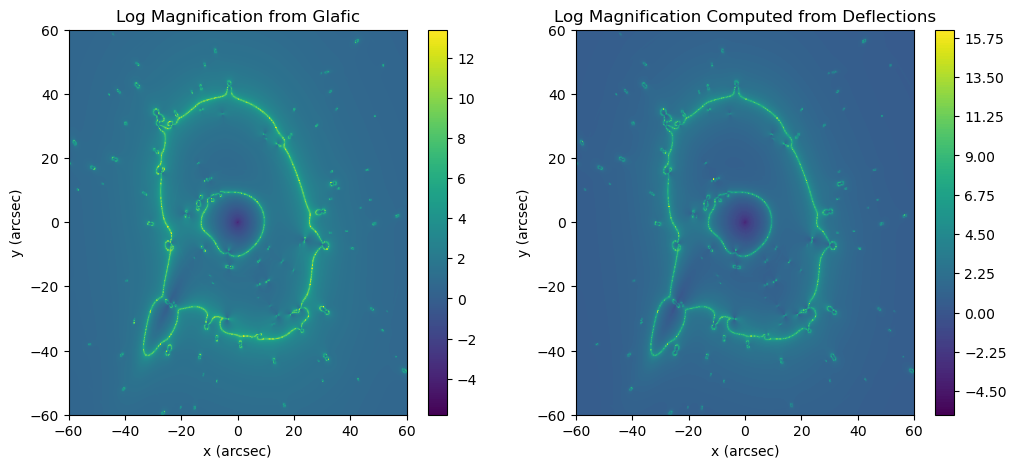

In [17]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.contourf(X,Y,np.log(magnif.native),levels=200)
plt.xlabel("x (arcsec)")
plt.ylabel("y (arcsec)")
plt.colorbar()
plt.title("Log Magnification from Glafic")

plt.subplot(1,2,2)
plt.contourf(X,Y,np.log(np.abs(deflections_magnif.native)),levels=200)
plt.xlabel("x (arcsec)")
plt.ylabel("y (arcsec)")
plt.colorbar()
plt.title("Log Magnification Computed from Deflections")